## 成交量与未平仓量


In [1]:
from datetime import datetime, timedelta

startTime = datetime(2022,11,12)
endTime = datetime(2023,1,19, 10)

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pymongo
import pandas as pd
import matplotlib.pyplot as plt
import talib as ta

In [4]:
symbolList = ['btc_usdt.spot:binance', 'eth_usdt.spot:binance']

client = pymongo.MongoClient('172.16.20.81', 27017)

In [5]:
def readDb(collection, start, end):
    return pd.DataFrame(
        list(collection.find({"datetime": {'$gt': start, '$lt': end}}))
    )

In [6]:

dbClient = client['Kline_1Min_Auto_Db_Plus']
columnsName = ['open', 'high', 'low', 'close', 'volume','datetime']

In [7]:
crytoDict = {
                'btc':readDb(dbClient[symbolList[0]], start=startTime , end=endTime)[columnsName],
                'eth':readDb(dbClient[symbolList[1]], start=startTime , end=endTime)[columnsName]
            }

In [8]:
def resampleDf(data, freq='H'):
#     df = data.drop('_id', axis=1)
    dataDf = data.set_index('datetime')
    dataHourDf = dataDf.resample(freq).agg({'open':'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume':'sum'})
    dataResetDf = dataHourDf.reset_index()
    return dataResetDf

def resampleOiDf(data, freq='H'):
    dataDf = data.set_index('datetime')
    dataHourDf = dataDf.resample(freq).agg({'oi':'last'})
    dataResetDf = dataHourDf.reset_index()
    return dataResetDf

In [9]:
def addSymbol(dataDf, symbolName):  
    dataDf['symbol'] = symbolName
    return dataDf

In [10]:
def setIndex(dataDf):
    dataIndex = dataDf.set_index(['datetime', 'symbol'])
    return dataIndex

In [11]:
multiCryptoDict = {}
for key, df in crytoDict.items():
    hourDf = resampleDf(df)
    hourSymbolDf = addSymbol(hourDf, key)
    hourIndexDf = setIndex(hourSymbolDf)
    multiCryptoDict[key] = hourIndexDf

In [12]:
multiDf = pd.concat(list(multiCryptoDict.values())).sort_index()

In [13]:
multiDf

open      high       low     close  \
datetime            symbol                                           
2022-11-12 00:00:00 btc     16900.78  16934.50  16543.95  16836.28   
                    eth      1262.54   1264.00   1233.24   1250.21   
2022-11-12 01:00:00 btc     16836.28  16963.71  16750.10  16909.31   
                    eth      1250.21   1278.87   1246.88   1274.30   
2022-11-12 02:00:00 btc     16909.31  17045.09  16802.07  16837.11   
...                              ...       ...       ...       ...   
2023-01-19 07:00:00 eth      1531.39   1533.28   1507.90   1511.43   
2023-01-19 08:00:00 btc     20677.47  20764.64  20660.15  20694.01   
                    eth      1511.44   1523.25   1509.15   1516.26   
2023-01-19 09:00:00 btc     20694.64  20775.85  20676.32  20716.95   
                    eth      1516.25   1523.80   1515.51   1518.14   

                                 volume  
datetime            symbol               
2022-11-12 00:00:00 btc     17333.46290  
                    eth     60945.74360  
2022-11-12 01:00:00 btc     13359.05393  
                    eth     49711.20880  
2022-11-12 02:00:00 btc     12471.61035  
...                                 ...  
2023-01-19 07:00:00 eth     21276.73540  
2023-01-19 08:00:00 btc     10081.58829  
                    eth     18232.28510  
2023-01-19 09:00:00 btc      7992.95494  
                    eth      8731.29020  

[3284 rows x 5 columns]

In [14]:
# 

In [15]:
btcOi = pd.read_csv('btcOi.csv')
ethOi = pd.read_csv('ethOi.csv')

In [16]:
btcOi.tail()

,Unnamed: 0,timestamp,oi,notional,datetime
14395,14395,1669791000,126590.723,2.132636e+09,2022-11-30 14:50:00
14396,14396,1669790700,126517.513,2.132946e+09,2022-11-30 14:45:00
14397,14397,1669790400,126299.743,2.127774e+09,2022-11-30 14:40:00
14398,14398,1669790100,126273.813,2.129229e+09,2022-11-30 14:35:00
14399,14399,1669789800,126196.443,2.126650e+09,2022-11-30 14:30:00


In [17]:
btcOiDf = btcOi[['oi', 'notional', 'datetime']]
ethOiDf = ethOi[['oi', 'notional', 'datetime']]

In [18]:
btcOiDf['datetime'] = list(map(lambda dt: datetime.strptime(dt, "%Y-%m-%d %H:%M:%S"), btcOiDf['datetime']))
ethOiDf['datetime'] = list(map(lambda dt: datetime.strptime(dt, "%Y-%m-%d %H:%M:%S"), ethOiDf['datetime']))

In [19]:
btcOi = setIndex(addSymbol(resampleOiDf(btcOiDf), 'btc'))
ethOi = setIndex(addSymbol(resampleOiDf(ethOiDf), 'eth'))

In [20]:
oiDf = pd.concat([btcOi, ethOi]).sort_index()

In [21]:
oiVolumeDf = pd.concat([multiDf, oiDf], axis=1).dropna()

In [22]:
oiVolumeDf

open      high       low     close  \
datetime            symbol                                           
2022-11-30 14:00:00 btc     16863.45  16870.77  16830.38  16860.80   
                    eth      1271.28   1271.98   1267.19   1269.18   
2022-11-30 15:00:00 btc     16860.61  16920.16  16858.90  16883.56   
                    eth      1269.17   1274.39   1268.16   1272.62   
2022-11-30 16:00:00 btc     16883.87  16930.66  16874.02  16890.65   
...                              ...       ...       ...       ...   
2023-01-19 07:00:00 eth      1531.39   1533.28   1507.90   1511.43   
2023-01-19 08:00:00 btc     20677.47  20764.64  20660.15  20694.01   
                    eth      1511.44   1523.25   1509.15   1516.26   
2023-01-19 09:00:00 btc     20694.64  20775.85  20676.32  20716.95   
                    eth      1516.25   1523.80   1515.51   1518.14   

                                 volume           oi  
datetime            symbol                            
2022-11-30 14:00:00 btc      7974.01943   126636.130  
                    eth     14776.07880  1321408.056  
2022-11-30 15:00:00 btc      8579.91183   127232.510  
                    eth     14222.15800  1328240.044  
2022-11-30 16:00:00 btc      7447.79347   127476.486  
...                                 ...          ...  
2023-01-19 07:00:00 eth     21276.73540  1117460.074  
2023-01-19 08:00:00 btc     10081.58829   102198.456  
                    eth     18232.28510  1126707.224  
2023-01-19 09:00:00 btc      7992.95494   102137.039  
                    eth      8731.29020  1129257.525  

[2392 rows x 6 columns]

In [23]:
btcOiVolumeDf = oiVolumeDf.loc[:,pd.IndexSlice['btc'],:]
ethOiVolumeDf = oiVolumeDf.loc[:,pd.IndexSlice['eth'],:]

In [24]:
shortPeriod = 168
longPeriod = shortPeriod*4

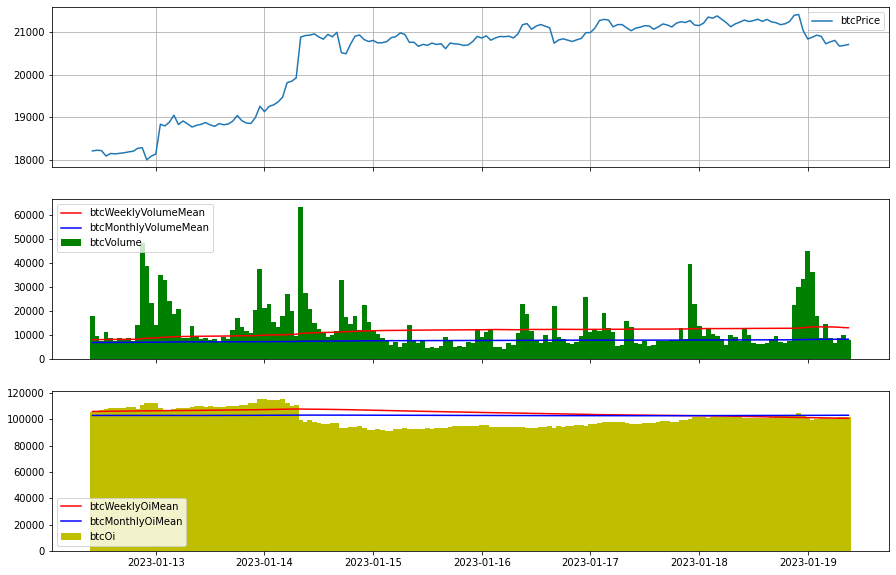

In [25]:
last7Day = 7*24
figBtc, (axBtc, ax1Btc, ax2Btc) = plt.subplots(3,1,sharex=True, figsize=(15,10))
# figBtc.subplots_adjust(bottom=0.5)
axBtc.grid(True)
axBtc.plot(btcOiVolumeDf.iloc[-last7Day:].close, label='btcPrice')
axBtc.legend()
ax1Btc.bar(btcOiVolumeDf.iloc[-last7Day:].index, btcOiVolumeDf.iloc[-last7Day:].volume, color='g', width=0.045, label='btcVolume')
ax1Btc.plot(ta.MA(btcOiVolumeDf.volume, shortPeriod).iloc[-last7Day:], color='r', label='btcWeeklyVolumeMean')
ax1Btc.plot(ta.MA(btcOiVolumeDf.volume, longPeriod).iloc[-last7Day:], color='b', label='btcMonthlyVolumeMean')
ax1Btc.legend(loc='upper left')
ax2Btc.bar(btcOiVolumeDf.iloc[-last7Day:].index, btcOiVolumeDf.oi.iloc[-last7Day:], color='y', width=0.045, label='btcOi')
ax2Btc.plot(ta.MA(btcOiVolumeDf.oi, shortPeriod).iloc[-last7Day:], color='r', label='btcWeeklyOiMean')
ax2Btc.plot(ta.MA(btcOiVolumeDf.oi, longPeriod).iloc[-last7Day:], color='b', label='btcMonthlyOiMean')
ax2Btc.legend()
figBtc.savefig('oiVolumePriceBtc')

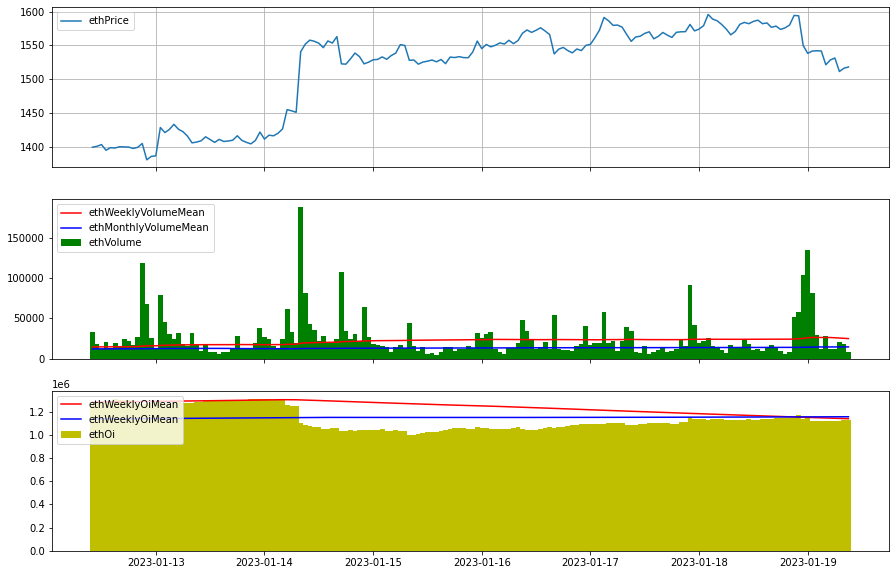

In [26]:
last7Day = 7*24
figEth, (axEth,ax1Eth, ax2Eth) = plt.subplots(3,1,sharex=True, figsize=(15,10))
# figEth.subplots_adjust(bottom=0.5)
axEth.grid(True)
axEth.plot(ethOiVolumeDf.iloc[-last7Day:].close, label='ethPrice')
axEth.legend(loc='upper left')
ax1Eth.bar(ethOiVolumeDf.iloc[-last7Day:].index, ethOiVolumeDf.iloc[-last7Day:].volume, color='g', width=0.045, label='ethVolume')
ax1Eth.plot(ta.MA(ethOiVolumeDf.volume, shortPeriod).iloc[-last7Day:], color='r', label='ethWeeklyVolumeMean')
ax1Eth.plot(ta.MA(ethOiVolumeDf.volume, longPeriod).iloc[-last7Day:], color='b', label='ethMonthlyVolumeMean')
ax1Eth.legend(loc='upper left')
ax2Eth.bar(ethOiVolumeDf.iloc[-last7Day:].index, ethOiVolumeDf.oi.iloc[-last7Day:], color='y', width=0.045, label='ethOi')
ax2Eth.plot(ta.MA(ethOiVolumeDf.oi, shortPeriod).iloc[-last7Day:], color='r', label='ethWeeklyOiMean')
ax2Eth.plot(ta.MA(ethOiVolumeDf.oi, longPeriod).iloc[-last7Day:], color='b', label='ethWeeklyOiMean')
ax2Eth.legend(loc='upper left')
figEth.savefig('oiVolumePriceEth')

In [27]:
close = oiVolumeDf.close.unstack()
volume = oiVolumeDf.volume.unstack()
oi = oiVolumeDf.oi.unstack()

In [28]:
oi

symbol,btc,eth
datetime,,
2022-11-30 14:00:00,126636.130,1321408.056
2022-11-30 15:00:00,127232.510,1328240.044
2022-11-30 16:00:00,127476.486,1330002.645
2022-11-30 17:00:00,127248.730,1324703.774
2022-11-30 18:00:00,127505.182,1317478.617
...,...,...
2023-01-19 05:00:00,100960.990,1121865.028
2023-01-19 06:00:00,101163.455,1123228.423
2023-01-19 07:00:00,101584.811,1117460.074


In [29]:
closeMaRatio = close.rolling(shortPeriod).mean()/close.rolling(longPeriod).mean()
volumeMaRatio = volume.rolling(shortPeriod).mean()/volume.rolling(longPeriod).mean()
oiMaRatio = oi.rolling(shortPeriod).mean()/oi.rolling(longPeriod).mean()

In [30]:
def cal_pctChange(data, lastDay, periodList=[7]):
    pctChangeDict = {}
    for period in periodList:
        pctChangeDict[str(period)+'Day'] = round((data.loc[lastDay]/data.loc[lastDay-timedelta(hours=period*24)]-1)*100, 2)
    pctChangeDf = pd.Series(pctChangeDict)
    return pctChangeDf

In [31]:
endTime = oiMaRatio.index[-1]
maChangeDf = pd.DataFrame({
    'btcCloseRatioPctChange': cal_pctChange(closeMaRatio.btc, endTime, [1, 3, 5, 8, 13]),
    'ethCloseRatioPctChange': cal_pctChange(closeMaRatio.eth, endTime, [1, 3, 5, 8, 13]),
    'btcVolumeRatioPctChange': cal_pctChange(volumeMaRatio.btc, endTime, [1, 3, 5, 8, 13]),
    'ethVolumeRatioPctChange': cal_pctChange(volumeMaRatio.eth, endTime, [1, 3, 5, 8, 13]),   
    'btcOpenInterestRatioPctChange': cal_pctChange(oiMaRatio.btc, endTime, [1, 3, 5, 8, 13]),
    'ethOpenInterestRatioPctChange': cal_pctChange(oiMaRatio.eth, endTime, [1, 3, 5, 8, 13]),
})

In [32]:
maChangeDfT = round(maChangeDf.T, 2)

In [33]:
maChangeDfT['avg'] = maChangeDfT.mean(axis=1)

In [34]:
maChangeDfT

,1Day,3Day,5Day,8Day,13Day,avg
btcCloseRatioPctChange,1.67,5.71,10.42,14.12,16.49,9.682
ethCloseRatioPctChange,1.11,3.85,7.70,11.55,16.87,8.216
btcVolumeRatioPctChange,-1.09,0.21,8.48,43.29,85.01,27.180
ethVolumeRatioPctChange,-1.48,-3.07,10.71,51.60,116.29,34.810
btcOpenInterestRatioPctChange,-1.69,-4.00,-6.43,-3.94,-4.70,-4.152
ethOpenInterestRatioPctChange,-2.86,-8.48,-12.81,-11.79,-4.58,-8.104


In [35]:
maChangeDfT.to_excel('RatioPctChange.xlsx')

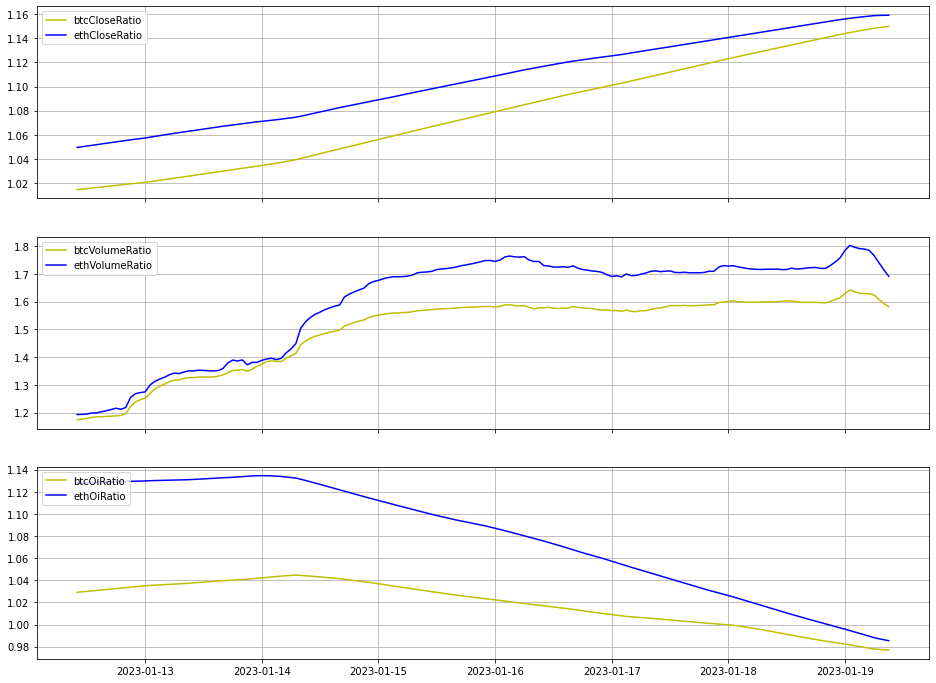

In [36]:
f2Coin, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(16,12))
ax1.plot(closeMaRatio.btc.iloc[-24*7:], 'y', label='btcCloseRatio')
ax1.plot(closeMaRatio.eth.iloc[-24*7:], 'b', label='ethCloseRatio')
ax1.legend(loc='upper left')
ax1.grid()
ax2.plot(volumeMaRatio.btc.iloc[-24*7:], 'y', label='btcVolumeRatio')
ax2.plot(volumeMaRatio.eth.iloc[-24*7:], 'b', label='ethVolumeRatio')
ax2.legend(loc='upper left')
ax2.grid()
ax3.plot(oiMaRatio.btc.iloc[-24*7:], 'y', label='btcOiRatio')
ax3.plot(oiMaRatio.eth.iloc[-24*7:], 'b', label='ethOiRatio')
ax3.legend(loc='upper left')
ax3.grid()
f2Coin.savefig('RatioChart')